In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Causal_Inference_Model/

/content/drive/MyDrive/Causal_Inference_Model


In [5]:
import sys, os

In [6]:
sys.path.append(os.path.abspath('scripts/'))

In [8]:
!pip install causalnex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 5.2 MB/s 
     |████████████████████████████████| 27.4 MB 78.6 MB/s 
     |████████████████████████████████| 1.9 MB 56.0 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 22.3 MB 41.8 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 115 kB 64.9 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68719 sha256=055447acc1628368407a43a977a023d8e1932af155f3151f99a7fc52b1c842f8
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: scikit-learn
    Found existing in

Import Libraries

In [11]:
import warnings
import pandas as pd
from causalnex.structure import StructureModel
from causal_pipeline import EDAPipeline
from causal_helper import CausalHelper
warnings.filterwarnings("ignore")

In [13]:
preprocessed_trip_df = pd.read_csv("data/processed_trip.csv")
preprocessed_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534369 entries, 0 to 534368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        534369 non-null  int64  
 1   Trip ID           534369 non-null  int64  
 2   Trip Origin       534369 non-null  object 
 3   Trip Destination  534369 non-null  object 
 4   Trip Start Time   534369 non-null  object 
 5   Trip End Time     534368 non-null  object 
 6   is_weekend        534369 non-null  int64  
 7   is_holiday        534369 non-null  int64  
 8   distance          534369 non-null  float64
 9   speed             534369 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 40.8+ MB


In [14]:
#Load the second data
df_driver = pd.read_csv("data/driver_locations_during_request.csv")
df_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1557740 non-null  int64  
 1   order_id       1557740 non-null  int64  
 2   driver_id      1557740 non-null  int64  
 3   driver_action  1557740 non-null  object 
 4   lat            1557740 non-null  float64
 5   lng            1557740 non-null  float64
 6   created_at     0 non-null        float64
 7   updated_at     0 non-null        float64
dtypes: float64(4), int64(3), object(1)
memory usage: 95.1+ MB


#### Merge the two Datasets

In [15]:
preprocessed_trip_df['driver_distance'] = preprocessed_trip_df['distance'].apply(lambda x: -1)
preprocessed_trip_df['driver_lat'] = preprocessed_trip_df['distance'].apply(lambda x: 0.0)
preprocessed_trip_df['driver_lng'] = preprocessed_trip_df['distance'].apply(lambda x: 0.0)

In [16]:
causalhelper = CausalHelper()

In [17]:
driver_lat,driver_lng = causalhelper.combine_get_driver_locations(preprocessed_trip_df, df_driver)

In [18]:
preprocessed_trip_df['driver_lat'] = driver_lat
preprocessed_trip_df['driver_lng'] = driver_lng

In [20]:
driver_lat_coordinates = preprocessed_trip_df['driver_lat'].tolist()
driver_lng_coordinates = preprocessed_trip_df['driver_lng'].tolist()
ending_coordinates = []
for i in range(len(driver_lat_coordinates)):
    ending_coordinates.append(f'{driver_lat_coordinates[i]},{driver_lng_coordinates[i]}')

In [21]:
start_coordinates = preprocessed_trip_df['Trip Origin'].tolist()

#### Calculate distance based on coordinates of driver

In [24]:
causal_pipeline = EDAPipeline()

In [25]:
preprocessed_trip_df['driver_distance'] = causal_pipeline.calculate_distances(start_coordinates, ending_coordinates)

Drop all the trips with -1 driver distance which means those orders were not in the 2nd dataset

In [26]:
preprocessed_trip_df_with_drivers = preprocessed_trip_df[preprocessed_trip_df['driver_distance']!=-1]
preprocessed_trip_df_with_drivers.shape

(26436, 13)

#### Compute unfulfilled orders

In [27]:
preprocessed_trip_df_with_drivers['is_fulfilled'] = preprocessed_trip_df_with_drivers['driver_distance'].apply(
    lambda x: 1 if x !=-2 else 0)

In [28]:
preprocessed_trip_df_with_drivers[preprocessed_trip_df_with_drivers['is_fulfilled']==0].shape

(609, 14)

#### Drop Unwanted columns

In [29]:
preprocessed_trip_df_with_drivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26436 entries, 4 to 53812
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        26436 non-null  int64  
 1   Trip ID           26436 non-null  int64  
 2   Trip Origin       26436 non-null  object 
 3   Trip Destination  26436 non-null  object 
 4   Trip Start Time   26436 non-null  object 
 5   Trip End Time     26436 non-null  object 
 6   is_weekend        26436 non-null  int64  
 7   is_holiday        26436 non-null  int64  
 8   distance          26436 non-null  float64
 9   speed             26436 non-null  float64
 10  driver_distance   26436 non-null  float64
 11  driver_lat        26436 non-null  float64
 12  driver_lng        26436 non-null  float64
 13  is_fulfilled      26436 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 3.0+ MB


#### Store data

In [30]:
preprocessed_trip_df_with_drivers.to_csv("data/preprocessed_drivers.csv")

In [31]:
cols = ['Trip ID','Unnamed: 0', 'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time', 'driver_lat', 'driver_lng']
preprocessed_trip_df_with_drivers = preprocessed_trip_df_with_drivers.drop(columns=cols)

In [32]:
preprocessed_trip_df_with_drivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26436 entries, 4 to 53812
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_weekend       26436 non-null  int64  
 1   is_holiday       26436 non-null  int64  
 2   distance         26436 non-null  float64
 3   speed            26436 non-null  float64
 4   driver_distance  26436 non-null  float64
 5   is_fulfilled     26436 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.4 MB


### Create Structural Model

In [33]:
smodel = StructureModel()

Create Edges
Transform and encode

In [34]:
import numpy as np

struct_data = preprocessed_trip_df_with_drivers.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

[]


In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

### Scale and normalize numerical data

In [36]:
from sklearn import preprocessing

x = struct_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

#### Apply the NOTEARS algorithm to learn the structure.

In [37]:
from causalnex.structure.notears import from_pandas

sm = from_pandas(df)

#### Visualize

In [42]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
!sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
python-dev is already the newest version (2.7.15~rc1-1).
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 27 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.3

In [45]:
!sudo pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pygraphviz-1.7.zip (118 kB)
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165753 sha256=aef14fb227891baa97142652df53ab96cbf14c3d1bdc2148550523045f337128
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


In [46]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE


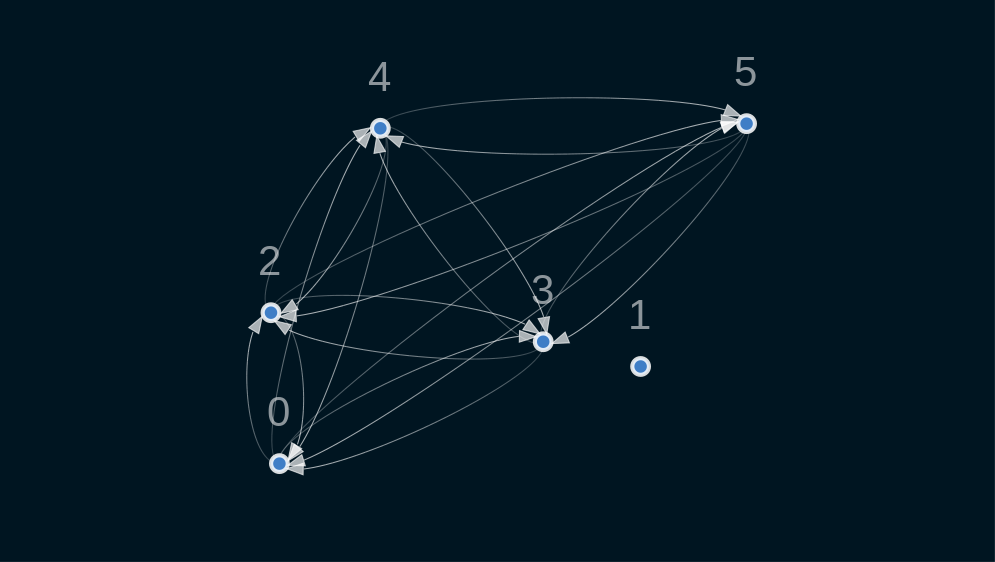

In [47]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

The reason why we have not a fully connected graph here is we haven’t applied thresholding to the weaker edges. Thresholding can be applied either by specifying the value for the parameter w_threshold in from_pandas, or we can remove the edges by calling the structure model function, remove_edges_below_threshold.

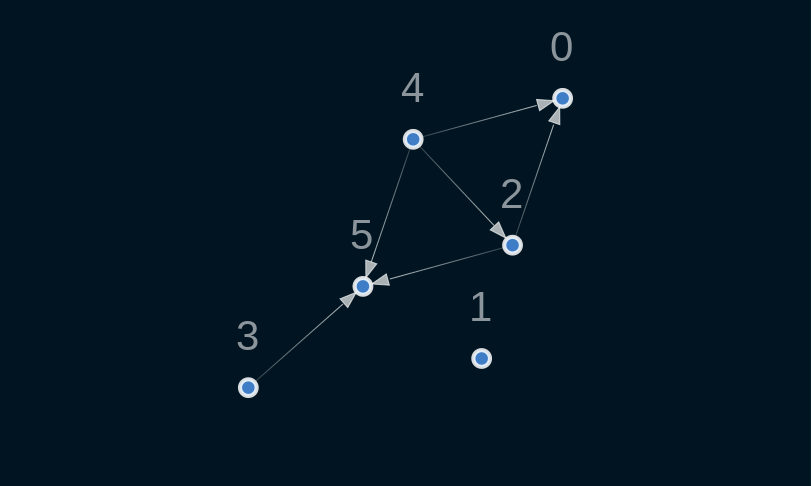

In [48]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))



Normalized column names
0 is_weekend
1 is_holiday

2 distance
3 speed
4 driver_distance
5 is_fulfilled

{'is_weekend': 0, 'is_holiday': 1, 'distance': 2, 'speed': 3, 'driver_distance': 4, 'is_fulfilled': 5}

    Correct relationships
    distance ---> is_fulfilled
    distance ---> is_fulfilled
    driver_distance ---> is_fulfilled

    Incorrect relationships
    distance ---> is_weekend
    driver_distance ---> is_weeken

Lets re-run structure learning with additional constraints to avoid incorrect relationships
Rename cols

In [49]:
df = df.rename(columns={0: "is_weekend", 1: "is_holiday", 2: "distance", 3: "speed",4: "driver_distance", 5: "is_fulfilled"}, errors="raise")

In [50]:
df

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
0,0.0,0.0,0.030832,0.018849,0.004094,1.0
1,0.0,0.0,0.011927,0.000770,0.006017,1.0
2,0.0,0.0,0.007388,0.000266,0.007518,1.0
3,0.0,0.0,0.008225,0.000519,0.004859,1.0
4,0.0,0.0,0.028036,0.001399,0.003340,1.0
...,...,...,...,...,...,...
26431,0.0,0.0,0.003773,0.000197,0.005521,1.0
26432,1.0,0.0,0.005256,0.001202,0.007197,1.0
26433,1.0,0.0,0.039313,0.001822,0.007742,1.0
26434,0.0,0.0,0.026934,0.000890,0.005839,1.0


In [51]:
sm = from_pandas(df, tabu_edges=[("driver_distance", "is_weekend"),("distance", "is_weekend")], w_threshold=0.8)

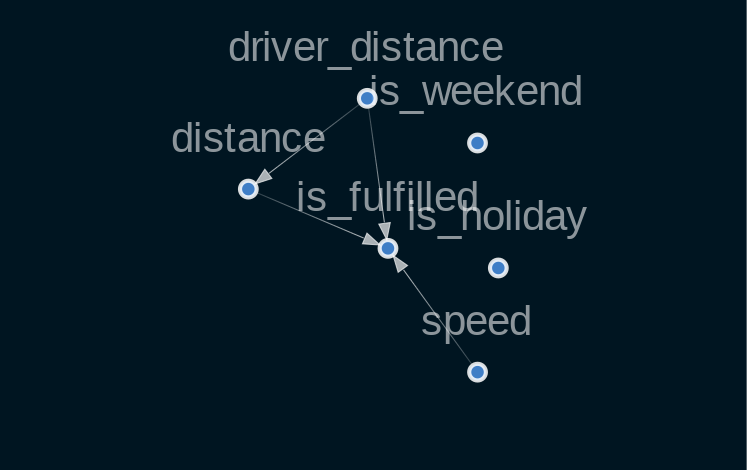

In [52]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))